R-squared (R2): 0.80
Mean Absolute Error (MAE): 170986.26


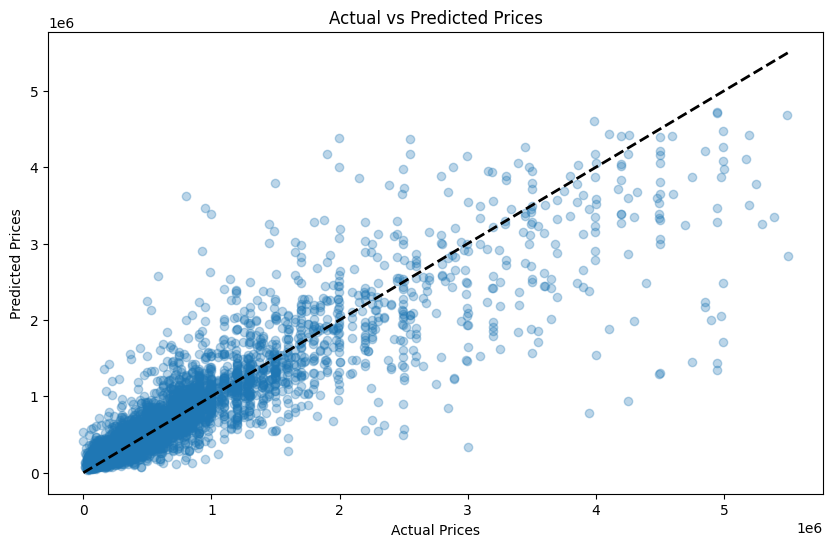

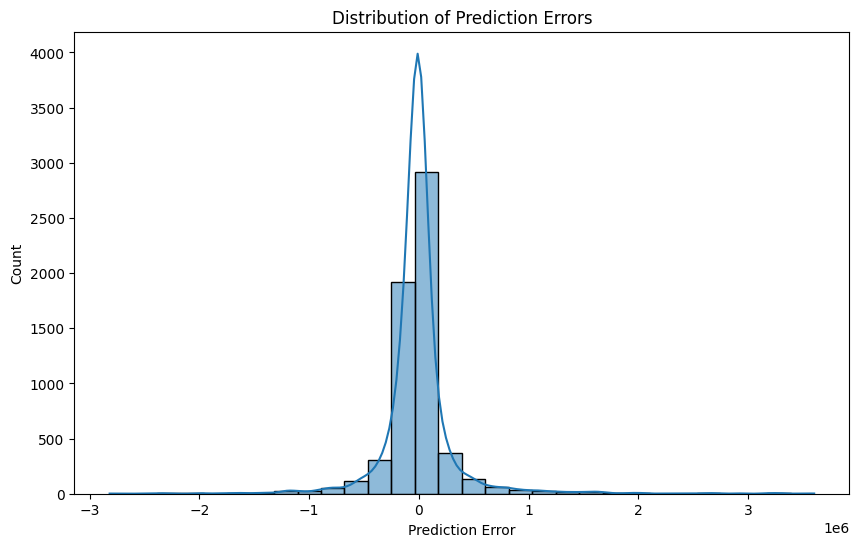

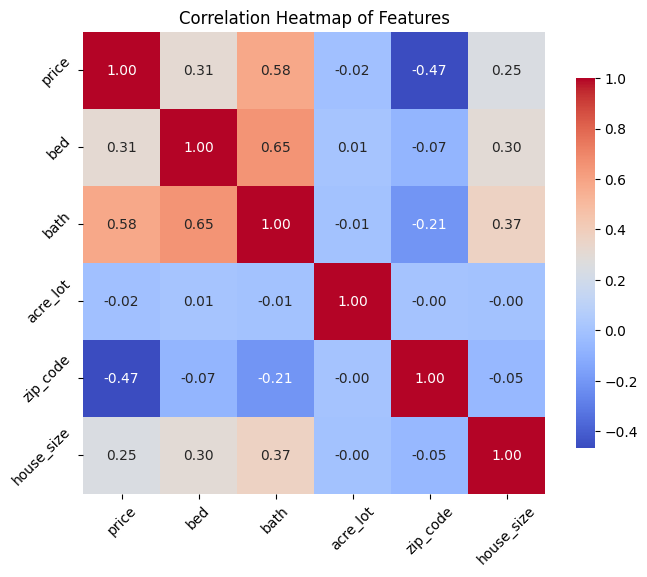

['random_forest_model.joblib']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Processing data
# data = pd.read_csv('realtor_data.csv')
# data = data[data['state'] == 'New York']
# data = data.drop(columns=['prev_sold_date', 'street', 'status', 'brokered_by', 'city', 'state'])
# data = data.dropna()
# mean_price = data['price'].mean()
# std_price = data['price'].std()
# data = data[(data['price'] <= mean_price + 2 * std_price) & (data['price'] >= mean_price - 2 * std_price)]
# data.to_csv('filtered_realtor_data.csv', index=False)

#Loading pre-processed data
filtered_data = pd.read_csv('filtered_realtor_data.csv')

# Select features and target for the Random Forest model
features = filtered_data[['bed', 'bath', 'zip_code', 'house_size', 'acre_lot']]
target = filtered_data['price']

# Target encoding
zip_code_avg_price = filtered_data.groupby('zip_code')['price'].mean().reset_index()
zip_code_avg_price.columns = ['zip_code', 'avg_price']

# Save the zip code average price mapping to a CSV file
zip_code_avg_price.to_csv('zip_code_avg_price.csv', index=False)

# If zipcode not found, fill with avg
features = features.merge(zip_code_avg_price, on='zip_code', how='left')
features['zip_code'] = features['zip_code'].fillna(features['avg_price'])

# Train and test data at 80/20 split
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns=['avg_price']), target, test_size=0.2, random_state=42)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, linestyle='--', color='black')
plt.show()

# Distribution of Errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.show()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Features')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

joblib.dump(model, 'random_forest_model.joblib')